In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
def reset_random_seeds(seeds):
   os.environ['PYTHONHASHSEED']=str(2)
   set_seed(seeds)
   np.random.seed(2022)
   random.seed(2022)

import random
import pandas as pd
import numpy as np
from zipfile import ZipFile
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install 'xgboost>=1.6'
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError as msle
from tensorflow.keras.models import load_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 39 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/GIT_AI


In [3]:
archive = ZipFile('DATA/store-sales-time-series-forecasting.zip', 'r')

In [4]:
archive.namelist()

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [5]:
train = pd.read_csv(archive.open("train.csv"))
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [6]:
test = pd.read_csv(archive.open("test.csv"))
test.head(10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


In [7]:
oil = pd.read_csv(archive.open("oil.csv"))
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
holidays = pd.read_csv(archive.open("holidays_events.csv"))
holidays.head(22)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [9]:
stores = pd.read_csv(archive.open("stores.csv"))
stores.sample(10)

,store_nbr,city,state,type,cluster
12,13,Latacunga,Cotopaxi,C,15
37,38,Loja,Loja,D,4
8,9,Quito,Pichincha,B,6
21,22,Puyo,Pastaza,C,7
45,46,Quito,Pichincha,A,14
3,4,Quito,Pichincha,D,9
30,31,Babahoyo,Los Rios,B,10
25,26,Guayaquil,Guayas,D,10
36,37,Cuenca,Azuay,D,2
6,7,Quito,Pichincha,D,8


In [10]:
transactions = pd.read_csv(archive.open("transactions.csv"))
transactions.head(15)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [11]:
archive.close()

# Data preparation

In [12]:
train.isnull().values.any()

False

## Joining information from other tables

**Replacing NaN value**

In [13]:
oil['dcoilwtico'].iloc[0] = oil['dcoilwtico'].iloc[1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
train = pd.merge(train, oil, on = "date", how = 'left')
test = pd.merge(test, oil, on = "date", how = 'left')

In [15]:
train.iloc[7125:7130]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
7125,7125,2013-01-04,9,PRODUCE,0.0,0,93.12
7126,7126,2013-01-04,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,93.12
7127,7127,2013-01-04,9,SEAFOOD,11.0,0,93.12
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,NaN
7129,7129,2013-01-05,1,BABY CARE,0.0,0,NaN


In [16]:
train.fillna(method='ffill', inplace=True)

In [17]:
train.iloc[7125:7130]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
7125,7125,2013-01-04,9,PRODUCE,0.0,0,93.12
7126,7126,2013-01-04,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,93.12
7127,7127,2013-01-04,9,SEAFOOD,11.0,0,93.12
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12
7129,7129,2013-01-05,1,BABY CARE,0.0,0,93.12


In [18]:
test.fillna(method='ffill', inplace=True)

In [22]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [23]:
holidays['locale'] = holidays['locale'].map({'Local': 1, 'Regional': 2, 'National': 3})
holidays = holidays[holidays.transferred == False]
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,1,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,2,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,1,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,1,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,1,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,3,Ecuador,Navidad-3,False
346,2017-12-23,Additional,3,Ecuador,Navidad-2,False
347,2017-12-24,Additional,3,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,3,Ecuador,Navidad,False


In [24]:
holidays = holidays[['date', 'locale']]
holidays.rename(columns={"locale": "holiday"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
train = pd.merge(train, holidays, on = "date", how = 'left')
test = pd.merge(test, holidays, on = "date", how = 'left')

In [26]:
train[train['date'] == '2013-11-02'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
550638,543510,2013-11-02,1,AUTOMOTIVE,4.000,0,94.56,3.0
550639,543511,2013-11-02,1,BABY CARE,0.000,0,94.56,3.0
550640,543512,2013-11-02,1,BEAUTY,2.000,0,94.56,3.0
550641,543513,2013-11-02,1,BEVERAGES,1030.000,0,94.56,3.0
550642,543514,2013-11-02,1,BOOKS,0.000,0,94.56,3.0
550643,543515,2013-11-02,1,BREAD/BAKERY,254.201,0,94.56,3.0
550644,543516,2013-11-02,1,CELEBRATION,0.000,0,94.56,3.0
550645,543517,2013-11-02,1,CLEANING,497.000,0,94.56,3.0
550646,543518,2013-11-02,1,DAIRY,419.000,0,94.56,3.0
550647,543519,2013-11-02,1,DELI,103.303,0,94.56,3.0


In [27]:
train[train['date'] == '2013-11-05'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
555984,548856,2013-11-05,1,AUTOMOTIVE,1.000,0,93.4,NaN
555985,548857,2013-11-05,1,BABY CARE,0.000,0,93.4,NaN
555986,548858,2013-11-05,1,BEAUTY,1.000,0,93.4,NaN
555987,548859,2013-11-05,1,BEVERAGES,853.000,0,93.4,NaN
555988,548860,2013-11-05,1,BOOKS,0.000,0,93.4,NaN
555989,548861,2013-11-05,1,BREAD/BAKERY,294.910,0,93.4,NaN
555990,548862,2013-11-05,1,CELEBRATION,0.000,0,93.4,NaN
555991,548863,2013-11-05,1,CLEANING,853.000,0,93.4,NaN
555992,548864,2013-11-05,1,DAIRY,591.000,0,93.4,NaN
555993,548865,2013-11-05,1,DELI,125.776,0,93.4,NaN


In [28]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [29]:
train[train['date'] == '2013-11-05'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
555984,548856,2013-11-05,1,AUTOMOTIVE,1.000,0,93.4,0.0
555985,548857,2013-11-05,1,BABY CARE,0.000,0,93.4,0.0
555986,548858,2013-11-05,1,BEAUTY,1.000,0,93.4,0.0
555987,548859,2013-11-05,1,BEVERAGES,853.000,0,93.4,0.0
555988,548860,2013-11-05,1,BOOKS,0.000,0,93.4,0.0
555989,548861,2013-11-05,1,BREAD/BAKERY,294.910,0,93.4,0.0
555990,548862,2013-11-05,1,CELEBRATION,0.000,0,93.4,0.0
555991,548863,2013-11-05,1,CLEANING,853.000,0,93.4,0.0
555992,548864,2013-11-05,1,DAIRY,591.000,0,93.4,0.0
555993,548865,2013-11-05,1,DELI,125.776,0,93.4,0.0


In [30]:
train = pd.merge(train, transactions, on = ['date', 'store_nbr'], how = 'left')
test = pd.merge(test, transactions, on = ['date', 'store_nbr'], how = 'left')

In [31]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [32]:
train.isnull().values.any()

False

In [33]:
test.isnull().values.any()

False

## EDA

In [ ]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [47]:
family_mean = train[['family', 'sales']].groupby('family').mean().sort_values(by='sales', ascending=False).reset_index()

In [ ]:
px.bar(family_mean, x="family", y="sales")

In [48]:
family_mean['sales'] = family_mean['sales']*100/sum(family_mean['sales'])

In [49]:
family_mapper = family_mean.set_index('family').T.to_dict(orient='index')['sales']

In [50]:
train['family'] = train['family'].map(family_mapper)
test['family'] = test['family'].map(family_mapper)

In [51]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [52]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [53]:
train.sample(10)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
id,,,,,,,,
873257,2014-05-07,11,1.335699,46.0,0,101.06,0.0,2579.0
1552297,2015-05-24,14,1.448255,43.0,0,58.88,3.0,1093.0
356669,2013-07-20,17,3.917647,231.0,0,108.00,0.0,1456.0
2054275,2016-03-01,48,2.288990,1164.0,7,34.39,0.0,2945.0
850904,2014-04-24,33,0.187095,0.0,0,102.20,0.0,1025.0
2909723,2017-06-25,50,0.009619,5.0,0,42.86,2.0,2973.0
934420,2014-06-10,27,2.288990,173.0,0,105.02,0.0,1191.0
2684261,2017-02-19,25,6.002656,332.0,10,53.41,0.0,667.0
1988177,2016-01-24,43,0.033341,0.0,0,32.07,0.0,1218.0


In [35]:
store_mean = train[['store_nbr', 'sales']].groupby('store_nbr').mean().sort_values(by='sales', ascending=False).reset_index()
px.bar(store_mean, x="store_nbr", y="sales")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   store_nbr     int64         
 2   family        float64       
 3   sales         float64       
 4   onpromotion   int64         
 5   dcoilwtico    float64       
 6   holiday       float64       
 7   transactions  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 209.7 MB


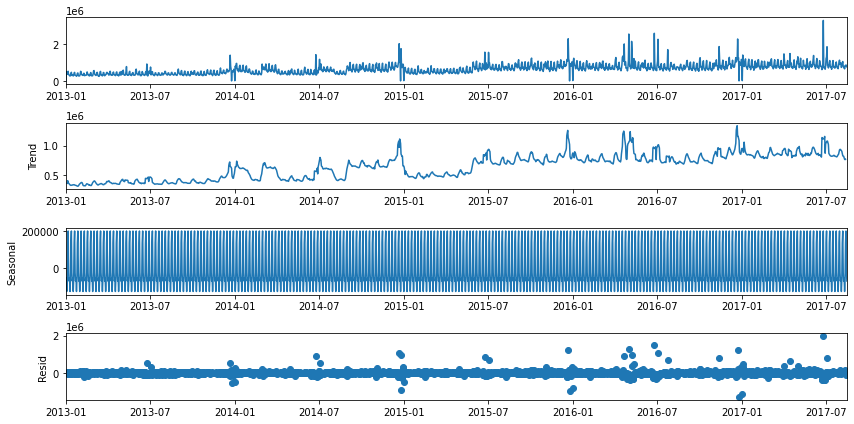

In [ ]:
sd = seasonal_decompose(train[['date', 'sales']].groupby('date').sum().asfreq('d').fillna(0), model='add')
fig = sd.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()

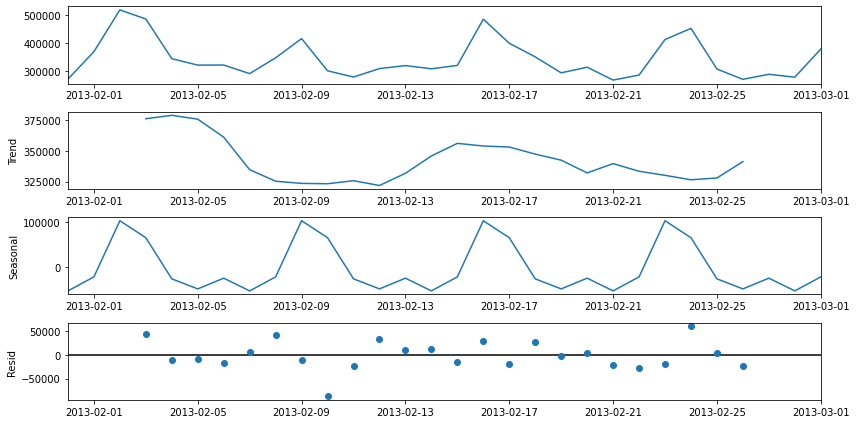

In [ ]:
sd = seasonal_decompose(train[['date', 'sales']].groupby('date').sum().asfreq('d').fillna(0).iloc[30:60], model='add')
fig = sd.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()

**`sales` seasonality is 7 days**

# XGBoost

In [54]:
train_multi_idx = train.set_index([train.index, 'date'])

In [55]:
X = train_multi_idx.drop(columns=['sales'])
y = train_multi_idx['sales']

Number of store as percent of mean sales.

In [56]:
store_mean['sales'] = store_mean['sales']*100/sum(store_mean['sales'])

In [57]:
store_mapper = store_mean.set_index('store_nbr').T.to_dict(orient='index')['sales']

In [58]:
X['store_nbr'] = X['store_nbr'].map(store_mapper)

80:20 train-test split

In [60]:
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [61]:
simple_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle')
simple_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=1)

[0]	validation_0-rmsle:1.41536
[1]	validation_0-rmsle:1.14460
[2]	validation_0-rmsle:1.07493
[3]	validation_0-rmsle:1.02706
[4]	validation_0-rmsle:1.04141
[5]	validation_0-rmsle:1.04439
[6]	validation_0-rmsle:nan
[7]	validation_0-rmsle:nan
[8]	validation_0-rmsle:nan
[9]	validation_0-rmsle:nan
[10]	validation_0-rmsle:nan
[11]	validation_0-rmsle:nan
[12]	validation_0-rmsle:nan
[13]	validation_0-rmsle:nan
[14]	validation_0-rmsle:nan
[15]	validation_0-rmsle:nan
[16]	validation_0-rmsle:nan
[17]	validation_0-rmsle:nan
[18]	validation_0-rmsle:nan
[19]	validation_0-rmsle:nan
[20]	validation_0-rmsle:nan
[21]	validation_0-rmsle:nan
[22]	validation_0-rmsle:nan
[23]	validation_0-rmsle:nan
[24]	validation_0-rmsle:nan
[25]	validation_0-rmsle:nan
[26]	validation_0-rmsle:nan
[27]	validation_0-rmsle:nan
[28]	validation_0-rmsle:nan
[29]	validation_0-rmsle:nan
[30]	validation_0-rmsle:nan
[31]	validation_0-rmsle:nan
[32]	validation_0-rmsle:nan
[33]	validation_0-rmsle:nan
[34]	validation_0-rmsle:nan
[35]	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [62]:
pred = simple_xgb.predict(X_test)
r2score(pred, y_test)

0.8963287746125947

Date as parameter, not index

In [63]:
train_date_param = train.drop(columns=['date'])
dates = pd.DatetimeIndex(train['date'])

train_date_param['year'] = dates.year
train_date_param['months'] = dates.month
train_date_param['days'] = dates.day
train_date_param.sample(10)

,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions,year,months,days
id,,,,,,,,,,
1782259,16,2.963268,76.87400,0,45.06,0.0,748.0,2015,9,30
1789034,7,3.917647,747.39197,2,45.54,0.0,1840.0,2015,10,3
2227328,53,0.033341,5.00000,0,49.71,0.0,1408.0,2016,6,6
367387,17,0.025030,0.00000,0,104.76,0.0,1099.0,2013,7,26
2704480,41,0.025030,0.00000,0,52.63,1.0,1039.0,2017,3,2
2399278,29,0.182839,8.00000,2,45.88,0.0,1364.0,2016,9,11
672603,30,11.439983,772.22650,0,92.15,0.0,750.0,2014,1,14
2076807,30,1.496434,109.00000,0,37.20,0.0,718.0,2016,3,14
2832181,25,0.723815,327.00000,5,47.83,3.0,1059.0,2017,5,13


In [66]:
X = train_date_param.drop(columns=['sales'])
y = train_date_param['sales']
X['store_nbr'] = X['store_nbr'].map(store_mapper)
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [69]:
date_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle')

date_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_xgb.predict(X_test)
r2score(y_test, pred)

0.9259372184363099

In [70]:
#lr=0.1 -> worse
#n_est=1000 -> 0.001 better
date_xgb2 = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle', learning_rate=0.15, n_jobs=-1)

date_xgb2.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_xgb2.predict(X_test)
r2score(y_test, pred)

0.9243567071815184

In [ ]:
final_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", learning_rate=0.3, n_jobs=-1)
final_xgb.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# import joblib
# joblib.dump(final_xgb,'final_xgb.joblib')

['final_xgb.joblib']

In [ ]:
test_date_param = test.drop(columns='date')
dates = pd.DatetimeIndex(test['date'])

test_date_param['year'] = dates.year
test_date_param['months'] = dates.month
test_date_param['days'] = dates.day
test_date_param.sample(10)

,store_nbr,family,onpromotion,dcoilwtico,holiday,transactions,year,months,days
id,,,,,,,,,
3023532,44,0.071085,0,46.40,0.0,0.0,2017,8,28
3029323,7,0.723815,2,47.26,0.0,0.0,2017,8,31
3005616,41,2.242038,52,48.59,0.0,0.0,2017,8,18
3025020,36,2.242038,8,46.46,0.0,0.0,2017,8,29
3013096,50,0.025030,13,47.65,0.0,0.0,2017,8,22
3027211,47,0.723815,2,45.96,0.0,0.0,2017,8,30
3006618,2,0.060606,1,48.59,0.0,0.0,2017,8,19
3006791,24,0.817703,0,48.59,0.0,0.0,2017,8,19
3024880,32,0.000942,0,46.46,0.0,0.0,2017,8,29


In [ ]:
xgb_pred = date_xgb.predict(test_date_param)

In [ ]:
xgb_test = test.copy()
xgb_test['sales'] = xgb_pred

In [ ]:
xgb_test.sales.to_csv('final_xgb.csv')

# RNN

In [ ]:
train.store_nbr.nunique()

54

In [ ]:
#SCALER
train_multi_idx = train.set_index([train.index, 'date'])
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(train_multi_idx['sales']))

MinMaxScaler()

In [ ]:
def data_split(data, store_num, scaler):
    
    X = data.groupby("store_nbr").get_group(store_num)['sales'] 

    X = pd.DataFrame(X)

    X_train, X_test = X.iloc[:-int(len(X)*0.2)], X.iloc[-int(len(X)*0.2):]

    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    
    return scaled_train, scaled_test
 

#RNN MODEL
def rnn_model():
    reset_random_seeds(2022)

    # define model
    model = Sequential()

    # Simple RNN layer
    model.add(SimpleRNN(64, input_shape=(length, 1)))

    # Final Prediction
    model.add(Dense(1))

    model.compile(optimizer='adam', loss=msle())
    
    return model        

In [ ]:
train_multi_idx.store_nbr.unique()[:10]

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
early_stop = EarlyStopping(monitor='val_loss', patience=2)
store_number = train_multi_idx.store_nbr.unique()

for i in store_number[:10]: #first 10 stores
    scaled_train, scaled_test = data_split(train_multi_idx, store_num=i, scaler=scaler)
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
    test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)
    rnn_model().fit(generator, epochs=10, 
                validation_data=test_generator, 
                callbacks=[early_stop]) 
    rnn_model().save(f'simpleRNN_store_{i}.h5')

In [ ]:
#test_pred = scaler.inverse_transform(model.predict(test_generator))